## Data Analysis for Round 1

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('./../')  # Add the parent directory to Python path
from plot_utils_CY import *

### Outline
1. Data Loading: Load your trading data into a Pandas DataFrame. This could be in the form of a CSV file, a database query result, or any other structured data format.
1. Data Cleaning: Clean the data by handling missing values, removing duplicates, and converting data types if necessary.
1. Data Manipulation: Perform data manipulation tasks such as calculating returns, creating new features, or aggregating data.
1. Data Analysis: Analyze the trading data using statistical methods and visualizations.
1. Performance Metrics: Calculate performance metrics such as Sharpe Ratio, Maximum Drawdown, and Win Rate.
1. Visualization: Visualize performance metrics and other relevant information using Matplotlib or other plotting libraries.

### Data Loading
* Loading price data and trade data into dataframes
* Merging data of the same format from different days

In [68]:
path = '../../shared_data/round1/'
days = [-2, -1, 0]

prices = [pd.read_csv(path + f'prices_round_1_day_{d}.csv', sep=';') for d in days]
price = pd.concat(prices)
price

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.0
2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,0.0
4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,999700,STARFRUIT,5053,1,5048.0,26.0,NaN,NaN,5054,2,5055.0,24.0,NaN,NaN,5053.5,0.0
19996,0,999800,STARFRUIT,5047,27,NaN,NaN,NaN,NaN,5052,1,5054.0,27.0,NaN,NaN,5049.5,0.0
19997,0,999800,AMETHYSTS,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0
19998,0,999900,STARFRUIT,5048,2,5047.0,21.0,NaN,NaN,5054,23,NaN,NaN,NaN,NaN,5051.0,0.0


In [101]:
trades = [pd.read_csv(path + f'trades_round_1_day_{d}_nn.csv', sep=';', ).assign(day=d) for d in days]
trade = pd.concat(trades)
trade

,timestamp,buyer,seller,symbol,currency,price,quantity,day
0,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1,-2
1,0,NaN,NaN,STARFRUIT,SEASHELLS,5003.0,1,-2
2,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1,-2
3,100,NaN,NaN,STARFRUIT,SEASHELLS,5004.0,6,-2
4,900,NaN,NaN,STARFRUIT,SEASHELLS,5001.0,2,-2
...,...,...,...,...,...,...,...,...
5312,998800,NaN,NaN,STARFRUIT,SEASHELLS,5050.0,1,0
5313,998800,NaN,NaN,AMETHYSTS,SEASHELLS,10002.0,1,0
5314,999500,NaN,NaN,AMETHYSTS,SEASHELLS,9995.0,2,0
5315,999500,NaN,NaN,STARFRUIT,SEASHELLS,5049.0,2,0


### Data Cleaning
* Counting the number of missing values in the data, per column

In [70]:
price.isna().sum()

day                    0
timestamp              0
product                0
bid_price_1            0
bid_volume_1           0
bid_price_2        26408
bid_volume_2       26408
bid_price_3        53602
bid_volume_3       53602
ask_price_1            0
ask_volume_1           0
ask_price_2        26994
ask_volume_2       26994
ask_price_3        53324
ask_volume_3       53324
mid_price              0
profit_and_loss        0
dtype: int64

In [102]:
trade.isna().sum()

timestamp        0
buyer        16150
seller       16150
symbol           0
currency         0
price            0
quantity         0
day              0
dtype: int64

### Data Manipulation
* Truncating the data for the backtester, take 10% of data from each day
* Calculating average daily pricing of products. Verifying if the average is the same as the `mid_price`

In [44]:
num_daily_row = price.shape[0] // 3
price_small = price[price['timestamp'] % num_daily_row < 2000]
price_small

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,AMETHYSTS,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,STARFRUIT,4997,26,NaN,NaN,NaN,NaN,5003,26,NaN,NaN,NaN,NaN,5000.0,0.0
2,-2,100,AMETHYSTS,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
3,-2,100,STARFRUIT,5000,5,4998.0,6.0,4997.0,20.0,5004,20,NaN,NaN,NaN,NaN,5002.0,0.0
4,-2,200,STARFRUIT,4997,1,4996.0,30.0,NaN,NaN,5003,31,NaN,NaN,NaN,NaN,5000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19635,0,981700,STARFRUIT,5050,31,NaN,NaN,NaN,NaN,5055,5,5057.0,31.0,NaN,NaN,5052.5,0.0
19636,0,981800,STARFRUIT,5050,22,NaN,NaN,NaN,NaN,5057,22,NaN,NaN,NaN,NaN,5053.5,0.0
19637,0,981800,AMETHYSTS,9995,22,NaN,NaN,NaN,NaN,10005,22,NaN,NaN,NaN,NaN,10000.0,0.0
19638,0,981900,STARFRUIT,5050,30,NaN,NaN,NaN,NaN,5057,30,NaN,NaN,NaN,NaN,5053.5,0.0


In [49]:
price_small.to_csv('truncated_price_data.csv', index=False) 

In [103]:
num_daily_row = price.shape[0] // 3
trade_small = trade[trade['timestamp'] % num_daily_row < 2000]
trade_small

,timestamp,buyer,seller,symbol,currency,price,quantity,day
0,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1,-2
1,0,NaN,NaN,STARFRUIT,SEASHELLS,5003.0,1,-2
2,0,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1,-2
3,100,NaN,NaN,STARFRUIT,SEASHELLS,5004.0,6,-2
4,900,NaN,NaN,STARFRUIT,SEASHELLS,5001.0,2,-2
...,...,...,...,...,...,...,...,...
5212,980800,NaN,NaN,AMETHYSTS,SEASHELLS,9996.0,1,0
5213,980900,NaN,NaN,STARFRUIT,SEASHELLS,5050.0,1,0
5214,981000,NaN,NaN,AMETHYSTS,SEASHELLS,10005.0,1,0
5215,981000,NaN,NaN,STARFRUIT,SEASHELLS,5050.0,1,0


In [104]:
trade_small.to_csv('truncated_trade_data.csv', index=False) 

### Data Visualization
For each day and each product, make a time series plot of 
* Line plot of `mid_price`
* Scatter plot of `bid_price_1` sized by `bid_volume_1`
* Scatter plot of `ask_price_1` sized by `ask_volume_1`
* Scatter plot of trading `price` sized by `quantity` (from `trade` dataframe)

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


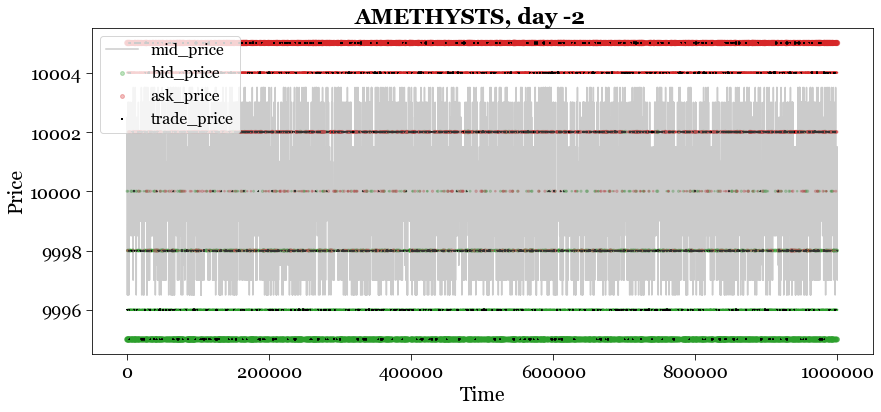

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


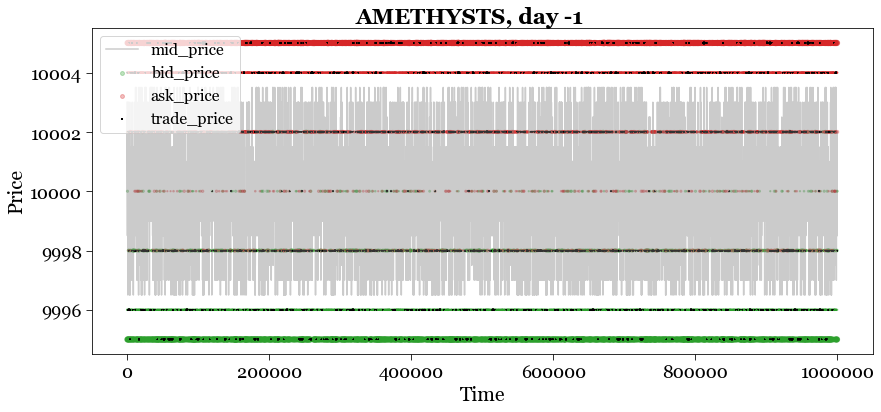

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


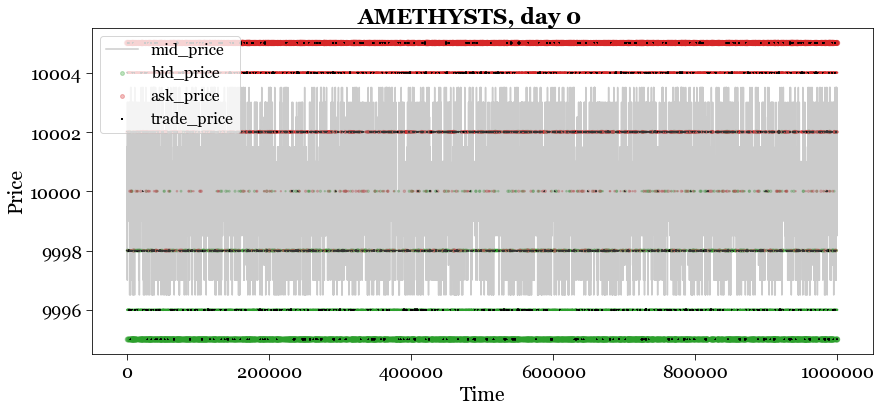

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


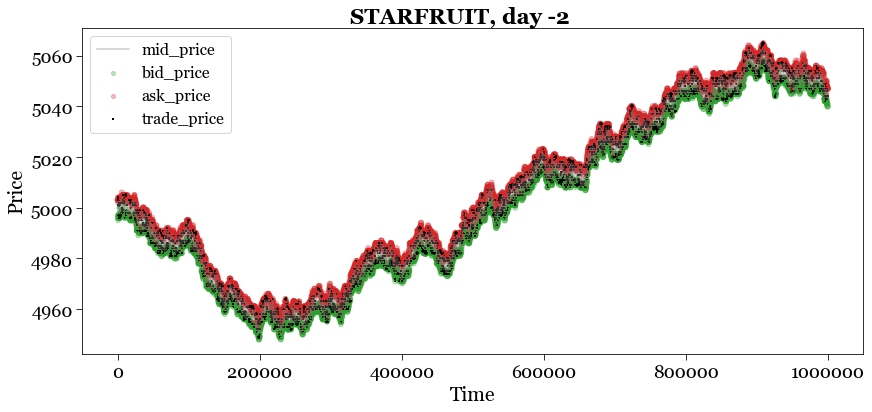

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


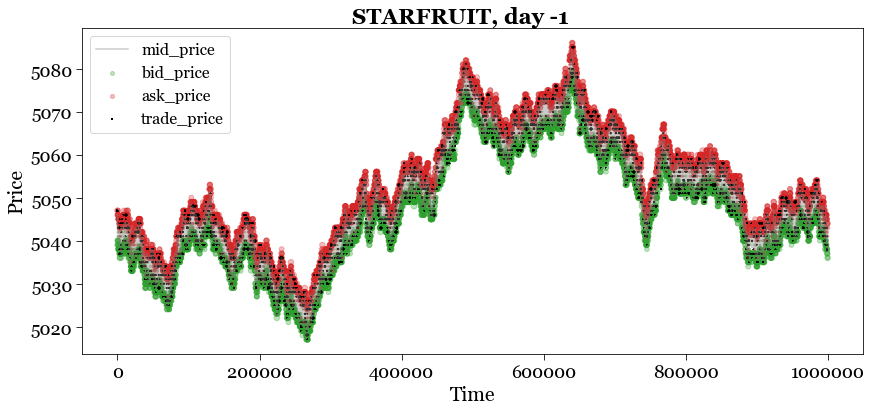

/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
/var/folders/h6/9mpjzmxd77l7493g4210phz00000gn/T/ipykernel_1548/84741762.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)


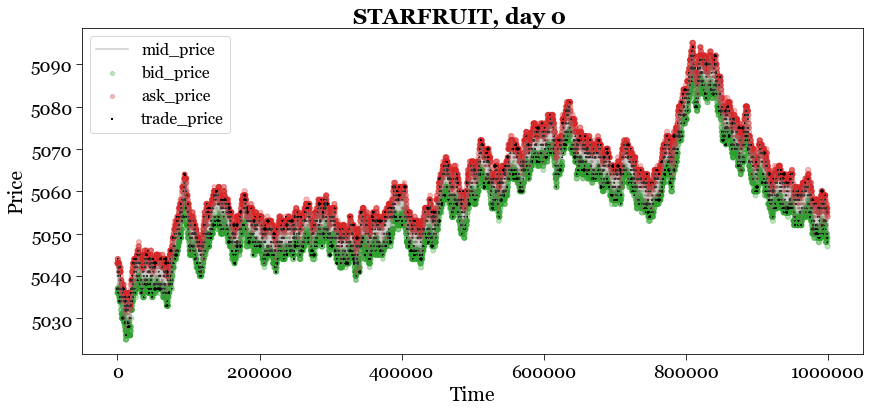

In [109]:
products = price['product'].unique()

for product in products:
    for day in days:
        filtered_trade = trade[(trade['day'] == day) & (trade['symbol'] == product)]
        filtered_price = price[(price['day'] == day) & (price['product'] == product)]
        fig = plt.figure(figsize=(14, 6))
        ax = plt.gca()

        xs = filtered_price['timestamp']
        mids = filtered_price['mid_price']
        bids = filtered_price['bid_price_1']
        asks = filtered_price['ask_price_1']
        ax.plot(xs, mids, label='mid_price', 
                color=tableau_colors[7], alpha=0.4)
        ax.scatter(xs, bids, label='bid_price', alpha=0.3,
                   color=tableau_colors[2], marker='o', s=filtered_price['bid_volume_1'])
        ax.scatter(xs, asks, label='ask_price', alpha=0.3,
                   color=tableau_colors[3], marker='o', s=filtered_price['ask_volume_1'])
        ax.scatter(filtered_trade['timestamp'], filtered_trade['price'], label='trade_price', alpha=1,
                   color='black', marker='+', s=filtered_trade['quantity'])

        # Customize tick sizes
        ax.tick_params(axis='both', which='major', labelsize=18, length=6)  # Adjust label size and tick length
        # ax.set_xlim(0, 2000)
        # ax.set_ylim(0, 12000)
        ax.set_xticklabels(ax.get_xticks(), fontdict=tick_font)
        ax.set_yticklabels(ax.get_yticks(), fontdict=tick_font)
        ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
        ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))

        # Customize the plot (optional)
        plt.xlabel('Time', fontdict=font)
        plt.ylabel('Price', fontdict=font)
        plt.gcf().set_facecolor('white')
        fig.suptitle(f'{product}, day {day}', fontproperties=suptitle_font, y=0.93)
        plt.legend(loc='upper left', prop=legend_font)

        # Show the plot
        plt.show()

### Data Analysis
* Perform Technical Analysis: Use technical analysis techniques to identify patterns, trends, and signals in the stock price data. Common technical indicators include moving averages, relative strength index (RSI), and Bollinger Bands. These indicators can help you identify entry and exit points for trades.
   - moving averages
   - relative strength index (RSI) 
   - Bollinger Bands
* Correlation study
* ARIMA modeling

#### ARIMA for AMETHYSTS

#### Moving Average for STARFRUIT

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Load time series data
data = pd.read_csv('your_time_series_data.csv')

# Fit ARIMA model
model = ARIMA(data, order=(p, d, q))
fit_model = model.fit()

# Make forecasts
forecasts = fit_model.forecast(steps=10)  # Example: Forecasting 10 steps ahead


### Performance Metrics